# LDC Implementation in Python/JAX
Written By: Sungje Park

In [1]:
import jax
from jax import numpy as jnp

import sys
sys.path.append('..')
from src.environment import *
from src.elements import *
from src.dynamics import *
from utils.test_utils import *
from src.methods import *
from tqdm import tqdm
import matplotlib.pyplot as plt

Defining Vars.

In [ ]:
rho_ref = 1 # reference density
Mu = .1 # kinematic Viscosity
Re = 100 # reynolds number
N_x = 100 # number of cells in the x dir
N_y = N_x # number of cells in the y dir
dx = 1 # spacing in x
dy = 1 # spacing in y
U_lid = Re*Mu/N_x # velocity of lid
Tau = 3*Mu+.5
dt = .1

In [3]:
cell_mesh = jnp.reshape(jnp.asarray(range(N_x*N_y)),(N_y,N_x))
node_mesh = jnp.reshape(jnp.asarray(range((N_x+1)*(N_y+1))),(N_y+1,N_x+1))
face_mesh = jnp.asarray(range(N_x*(N_y+1)+(N_x+1)*N_y))
vert_mesh = jnp.reshape(face_mesh[0:N_x*(N_y+1)],(N_y,N_x+1))
horz_mesh = jnp.reshape(face_mesh[N_x*(N_y+1):],(N_y+1,N_x))

In [4]:
dynamics = D2Q9(tau=Tau,delta_t = dt)
Element.dynamics = dynamics
Environment.dynamics = dynamics

In [5]:
def create_cell(cell_ind):
    loc = jnp.argwhere(cell_mesh == cell_ind)[0]
    x = loc[1]
    y = loc[0]
    pdf = dynamics.ones_pdf()
    face_ind = jnp.asarray([vert_mesh[y,x],
                            horz_mesh[y,x],
                            vert_mesh[y,x+1],
                            horz_mesh[y+1,x]])
    face_n = jnp.asarray([-1,-1,1,1])
    return Cell.pdf_init(pdf,face_ind,face_n)

cells = [create_cell(ind) for ind in tqdm(range(N_x*N_y))]

100%|██████████| 100/100 [00:01<00:00, 52.76it/s]


In [6]:
def create_node(node_ind):
    loc = jnp.argwhere(node_mesh==node_ind)[0]
    x = loc[1]
    y = loc[0]
    pdf = dynamics.ones_pdf()
    cell_index = []
    cell_dists = []
    cell_dist = jnp.sqrt(2)
    def cell_append(tl,tr,bl,br):
        if tl:
            cell_index.append(cell_mesh[y-1,x-1]) # top left
            cell_dists.append(cell_dist)
        if tr:
            cell_index.append(cell_mesh[y-1,x]) # top right
            cell_dists.append(cell_dist)

        if br:
            cell_index.append(cell_mesh[y,x]) # bottom right
            cell_dists.append(cell_dist)

        if bl:
            cell_index.append(cell_mesh[y,x-1])# bottom left
            cell_dists.append(cell_dist)

    if y == 0:
        type = 1
        vel = jnp.asarray([U_lid,0])
        if x!=0 and x!=N_x:
            cell_append(False,False,True,True)
        elif x==0:
            vel = jnp.asarray([0,0])
            cell_append(False,False,False,True)
        elif x==N_x:
            vel = jnp.asarray([0,0])
            cell_append(False,False,True,False)

    elif y == N_y:
        type = 1
        vel = jnp.asarray([0,0])
        if x!=0 and x!=N_x:
            cell_append(True,True,False,False)
        elif x==0:
            cell_append(False,True,False,False)
        elif x==N_x:
            cell_append(True,False,False,False)

    elif x == 0:
        type = 1
        vel = jnp.asarray([0,0])
        # since all corner cases handled
        cell_append(False,True,False,True)

    elif x == N_x:
        type = 1
        vel = jnp.asarray([0,0])
        cell_append(True,False,True,False)
    else:
        type = 0
        cell_append(True,True,True,True)

    node = Node.pdf_init(pdf,jnp.asarray(type),jnp.asarray(cell_index),jnp.asarray(cell_dists))

    if type == 1:
        node.vel = vel
    return node
nodes = [create_node(ind) for ind in tqdm(range((N_x+1)*(N_y+1)))]

100%|██████████| 121/121 [00:02<00:00, 53.95it/s]


In [7]:
def create_face(face_ind):
    pdf = dynamics.ones_pdf()
    nodes_ind = []
    stencil_ind = []
    stencil_dists = jnp.asarray([.5,.5])
    
    if face_ind < N_x*(N_y+1): # vertical faces
        loc = jnp.argwhere(vert_mesh==face_ind)[0]
        x = loc[1]
        y = loc[0]
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y,x]].type,node_mesh[y,x]]))
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y+1,x]].type,node_mesh[y+1,x]]))

        if x == 0:
            stencil_ind.append(-1)
            stencil_ind.append(cell_mesh[y,x])
        elif x == N_x:
            stencil_ind.append(cell_mesh[y,x-1])
            stencil_ind.append(-1)
        else:
            stencil_ind.append(cell_mesh[y,x-1])
            stencil_ind.append(cell_mesh[y,x])

        n = jnp.asarray([1,0])
    else: # horizontal faces
        loc = jnp.argwhere(horz_mesh==face_ind)[0]
        x = loc[1]
        y = loc[0]
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y,x]].type,node_mesh[y,x]]))
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y,x+1]].type,node_mesh[y,x+1]]))

        if y == 0:
            stencil_ind.append(-1)
            stencil_ind.append(cell_mesh[y,x])
        elif y == N_y:
            stencil_ind.append(cell_mesh[y-1,x])
            stencil_ind.append(-1)
        else:
            stencil_ind.append(cell_mesh[y-1,x])
            stencil_ind.append(cell_mesh[y,x])

        n = jnp.asarray([0,1])

    face = Face.pdf_init(pdf,jnp.asarray(nodes_ind),jnp.asarray(stencil_ind),jnp.asarray(stencil_dists),n,jnp.asarray(1))
    return face

faces = [create_face(ind) for ind in tqdm(range((N_x)*(N_x+1)*2))]

100%|██████████| 220/220 [00:03<00:00, 58.97it/s]


In [8]:
env = Environment.create(cells,faces,nodes)
env.setMethods(Methods)
params,config = env.init()

In [9]:
params

{'cells': {'pdf': Array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.

In [10]:
params = env.step(params,config)
params

{'cells': {'pdf': Array([[1.375  , 1.     , 0.9985 , 1.     , 1.     , 0.9145 , 0.8995 ,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.997  , 1.     , 1.     , 0.92275, 0.89275,
          0.90625, 0.90625],
         [1.375  , 1.     , 0.9985 , 1.     , 1.     , 0.9145 , 0.

In [11]:
params = env.step(params,config)
params

{'cells': {'pdf': Array([[1.7031229 , 0.9998748 , 0.9971134 , 0.99937606, 0.99999946,
          0.83934295, 0.8107058 , 0.82406276, 0.82418746],
         [1.7031167 , 1.0012542 , 0.9944506 , 0.99875414, 0.9999979 ,
          0.85379344, 0.79936844, 0.8239073 , 0.8245323 ],
         [1.7031167 , 1.0012542 , 0.99437624, 0.99875414, 0.9999979 ,
          0.85496813, 0.7990931 , 0.8239073 , 0.8245323 ],
         [1.7031167 , 1.0012542 , 0.99437624, 0.99875414, 0.9999979 ,
          0.85496813, 0.7990931 , 0.8239073 , 0.8245323 ],
         [1.7031167 , 1.0012542 , 0.99437624, 0.99875414, 0.9999979 ,
          0.85496813, 0.7990931 , 0.8239073 , 0.8245323 ],
         [1.7031167 , 1.0012542 , 0.99437624, 0.99875414, 0.9999979 ,
          0.85496813, 0.7990931 , 0.8239073 , 0.8245323 ],
         [1.7031167 , 1.0012542 , 0.99437624, 0.99875414, 0.9999979 ,
          0.85496813, 0.7990931 , 0.8239073 , 0.8245323 ],
         [1.7031167 , 1.0012542 , 0.99437624, 0.99875414, 0.9999979 ,
          0

In [12]:
params = env.step(params,config)
params

{'cells': {'pdf': Array([[1.9901016 , 0.9995831 , 0.99583685, 0.9981459 , 1.0000122 ,
          0.773283  , 0.732465  , 0.7520047 , 0.7523335 ],
         [1.9901506 , 1.0033612 , 0.9922763 , 0.9965158 , 1.0000136 ,
          0.7924595 , 0.71797097, 0.75161   , 0.7532591 ],
         [1.9901948 , 1.0035719 , 0.99210143, 0.99646765, 0.99999034,
          0.795309  , 0.7173343 , 0.7515895 , 0.753303  ],
         [1.9901948 , 1.0035719 , 0.992084  , 0.99646765, 0.99999034,
          0.79547596, 0.7173228 , 0.7515895 , 0.753303  ],
         [1.9901948 , 1.0035719 , 0.992084  , 0.99646765, 0.99999034,
          0.79547596, 0.7173228 , 0.7515895 , 0.753303  ],
         [1.9901948 , 1.0035719 , 0.992084  , 0.99646765, 0.99999034,
          0.79547596, 0.7173228 , 0.7515895 , 0.753303  ],
         [1.9901948 , 1.0035719 , 0.992084  , 0.99646765, 0.99999034,
          0.79547596, 0.7173228 , 0.7515895 , 0.753303  ],
         [1.9901948 , 1.0035719 , 0.99207634, 0.99646765, 0.99999034,
          0

In [13]:
params = env.step(params,config)
params

{'cells': {'pdf': Array([[2.2409756 , 0.99911207, 0.99465984, 0.9963621 , 1.0000322 ,
          0.71521556, 0.66365975, 0.68882155, 0.68940324],
         [2.2411854 , 1.0060197 , 0.9904146 , 0.99348766, 1.0000522 ,
          0.73804337, 0.6469706 , 0.688144  , 0.6910673 ],
         [2.241343  , 1.0067537 , 0.9901399 , 0.99332577, 0.9999789 ,
          0.74270135, 0.64597905, 0.6880784 , 0.6912165 ],
         [2.2413504 , 1.0067842 , 0.99008715, 0.9933204 , 0.999975  ,
          0.7432189 , 0.64594626, 0.68807566, 0.6912218 ],
         [2.2413504 , 1.0067842 , 0.99008405, 0.9933204 , 0.999975  ,
          0.7432426 , 0.6459458 , 0.68807566, 0.6912218 ],
         [2.2413504 , 1.0067842 , 0.99008405, 0.9933204 , 0.999975  ,
          0.7432426 , 0.6459458 , 0.68807566, 0.6912218 ],
         [2.2413504 , 1.0067842 , 0.9900817 , 0.9933204 , 0.999975  ,
          0.74324214, 0.6459648 , 0.68807566, 0.6912218 ],
         [2.2413568 , 1.0067794 , 0.99005824, 0.99334556, 0.9999719 ,
          0

In [14]:
params = env.step(params,config)
params

{'cells': {'pdf': Array([[2.4601724 , 0.99846494, 0.9935683 , 0.994093  , 1.0000466 ,
          0.6641655 , 0.60324156, 0.6334149 , 0.6342778 ],
         [2.4606757 , 1.0090036 , 0.98881274, 0.98983526, 1.0001103 ,
          0.68985105, 0.5850146 , 0.63243395, 0.6367811 ],
         [2.4610295 , 1.0106091 , 0.9884543 , 0.9894919 , 0.9999661 ,
          0.69626164, 0.5837154 , 0.6323007 , 0.6371007 ],
         [2.4610605 , 1.010738  , 0.9883538 , 0.98947   , 0.9999512 ,
          0.6972734 , 0.5836569 , 0.63229007, 0.63712245],
         [2.4610615 , 1.0107424 , 0.98834205, 0.9894693 , 0.9999506 ,
          0.697363  , 0.5836555 , 0.6322897 , 0.6371231 ],
         [2.4610615 , 1.0107424 , 0.9883412 , 0.9894693 , 0.9999506 ,
          0.69736636, 0.58365816, 0.6322897 , 0.6371231 ],
         [2.4610624 , 1.0107418 , 0.9883325 , 0.98947287, 0.9999502 ,
          0.6973648 , 0.58373076, 0.63229024, 0.6371228 ],
         [2.4610903 , 1.010722  , 0.98828757, 0.98957866, 0.9999384 ,
          0

In [15]:
params = env.step(params,config)
params

{'cells': {'pdf': Array([[2.6515791 , 0.9976541 , 0.9925466 , 0.9914115 , 1.0000412 ,
          0.61927456, 0.5502479 , 0.5848223 , 0.5859816 ],
         [2.6525226 , 1.0121447 , 0.9874254 , 0.98569584, 1.00018   ,
          0.64722383, 0.53093934, 0.58353037, 0.5893831 ],
         [2.653164  , 1.0149657 , 0.9870084 , 0.9851078 , 0.9999535 ,
          0.6552419 , 0.52939427, 0.58331114, 0.5899345 ],
         [2.6532426 , 1.0152936 , 0.98685473, 0.98505384, 0.99991906,
          0.6568382 , 0.52931124, 0.58328617, 0.589989  ],
         [2.6532476 , 1.0153152 , 0.9868282 , 0.9850505 , 0.9999165 ,
          0.6570426 , 0.5293092 , 0.58328444, 0.5899921 ],
         [2.6532478 , 1.0153158 , 0.98682433, 0.9850509 , 0.9999163 ,
          0.6570577 , 0.5293213 , 0.58328444, 0.58999217],
         [2.6532526 , 1.0153128 , 0.9868043 , 0.9850684 , 0.99991435,
          0.65705544, 0.5294888 , 0.583287  , 0.5899907 ],
         [2.6533258 , 1.0152632 , 0.9867354 , 0.985337  , 0.9998874 ,
          0

In [16]:
for i in tqdm(range(10000)):
    params = env.step(params,config)

100%|██████████| 10000/10000 [00:00<00:00, 16729.29it/s]


In [17]:
params

{'cells': {'pdf': Array([[5.320435  , 1.3259914 , 1.3448149 , 1.2314193 , 1.4229463 ,
          0.40234703, 0.25763947, 0.33469328, 0.3434765 ],
         [5.4693274 , 1.4491394 , 1.3624191 , 1.2081676 , 1.4561522 ,
          0.4542958 , 0.23491086, 0.3297789 , 0.37893236],
         [5.62298   , 1.55828   , 1.3957025 , 1.2082978 , 1.4725065 ,
          0.4829232 , 0.24034122, 0.32677165, 0.40136713],
         [5.7489414 , 1.6467327 , 1.4240445 , 1.2175025 , 1.4829898 ,
          0.4998959 , 0.24728763, 0.32533038, 0.41571426],
         [5.857753  , 1.7149401 , 1.4481395 , 1.2358553 , 1.49134   ,
          0.51143354, 0.25341123, 0.32567522, 0.42491335],
         [5.9621644 , 1.7655972 , 1.4703114 , 1.2655499 , 1.4993879 ,
          0.52109426, 0.25947237, 0.32811728, 0.43051964],
         [6.0742874 , 1.8015862 , 1.4928277 , 1.3096886 , 1.5083281 ,
          0.53105056, 0.26725975, 0.33319864, 0.43331522],
         [6.206327  , 1.8249507 , 1.5182462 , 1.3717972 , 1.5192434 ,
          0

In [18]:
vel = params["cells"]["vel"]

In [28]:
x = jnp.linspace(1/2/N_x,1-1/2/N_x,N_x)
y = jnp.linspace(1/2/N_y,1-1/2/N_y,N_y)
# x,y = jnp.meshgrid(x,y)
# x = x.flatten()
# y = y.flatten()

In [29]:
x.shape

(10,)

In [30]:
vel[...,0].shape

(100,)

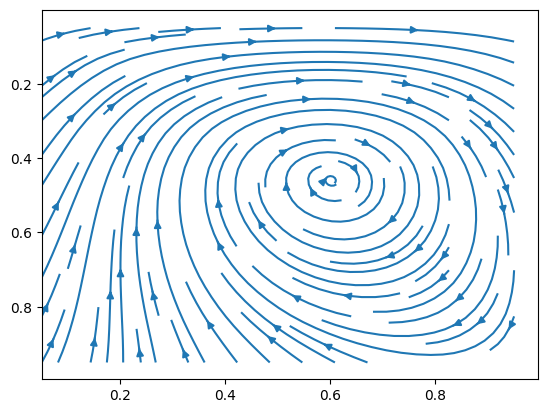

In [38]:
import numpy as np
x = np.asarray(x)
y = np.asarray(y)
u = np.asarray(vel[...,0].reshape(N_x,N_y))
v = np.asarray(vel[...,1].reshape(N_x,N_y))
plt.streamplot(x,y,u,v)
plt.gca().invert_yaxis()
plt.show()